Define all functions
====

In [2]:
import numpy as np
from numpy import pi
from scipy.integrate import ode

mrand=lambda: 2*np.random.rand()-1 # shortcut random number between -1 and 1
def roll(arr,tup):
    '''a shortcut. roll(arr,(S1,S2)) applies roll with S1 steps on 1st axis and then with S2 on the 2nd one'''
    return np.roll(np.roll(arr,tup[0],axis=0),tup[1],axis=1)

def generate_v_field(n=17,max_periods=4):
    '''Generates a random divergence-less velocity field on the periodic domain [0,2*pi]x[0,2*pi].
       n - number of sinusoidal terms
       max_periods - maximal periods each term has over the domain 2pi (large value = high frequency)
    '''
    x,y=np.meshgrid(np.linspace(0,2*pi,N+1)[:-1],
                    np.linspace(0,2*pi,N+1)[:-1])
    u=0*x;
    v=0*x;
    for i in xrange(n):
        A=np.random.randn()
        nx=np.round(max_periods*mrand())
        ny=np.round(max_periods*mrand())
        phi=pi*mrand()
        u+=A*ny*np.sin(nx*x+ny*y+phi)
        v-=A*nx*np.sin(nx*x+ny*y+phi)
    return u,v

def velocity_dot_grad_c(u,v,C):
    '''calculates the advective derivative of C with the velocity field (u,v)/
       That is, u dC/dx+v dC/dy'''
    
    return  (
            (0.25/dx)*(
             (C+roll(C,[0,-1]))*(roll(u,[1,-1])+roll(u,[0,-1]))-
             (C+roll(C,[0, 1]))*(roll(u,[0, 0])+roll(u,[1, 0])))+
            (0.25/dx)*(
             (C+roll(C,[-1, 0]))*(roll(v,[0,0])+roll(v,[0,-1]))-
             (C+roll(C,[ 1, 0]))*(roll(v,[1,-1])+roll(v,[1,0])))
            )

def laplacian(C):
    '''calculates the laplacian of C'''
    return (
            roll(C,[-1,0])+roll(C,[0,-1])+roll(C,[1,0])+roll(C,[0,1])-4*C
            )/(dx**2)

def dvdt_maker(u,v,eta,sources):
    '''returns a function that calculates the time derivative but is usable in the integrator that needs a vector
       input rather than a matrix.'''
    return lambda t,C: Cdot(C.reshape(N,N),u,v,eta,sources).flatten()

def Cdot(C,u,v,eta,sources):
    '''Returns the time derivative of the concentration field C, under diffusion and advection
       C        - concentration field
       (u,v)    - components of velocity field
       eta      - diffusion constant
       sources  - sources (and sinks)'''
    return -velocity_dot_grad_c(u,v,C)+eta*laplacian(C)+sources

def point_sources():
    z=np.zeros([N,N])
    z[np.round(N/4),np.round(N/4)]=1
    z[np.round(3*N/4),np.round(3*N/4)]=-1
    return z

def gauss_sources(width=0.2,randomize_positions=False):
    x,y=np.meshgrid(np.linspace(0,2*pi,N+1)[:-1],
                np.linspace(0,2*pi,N+1)[:-1])
    q=np.exp(-((x-pi)/width)**2-((y-pi)/width)**2)

    if randomize_positions:
        return roll(q,[int(N*mrand()) for i in [1,2]])-roll(q,[int(N*mrand()) for i in [1,2]])
    else:
        return roll(q,[N/4,N/4])-roll(q,[-N/4,-N/4])

def calculate_steady_plume(eta,
                           number_of_points=200,
                           tolerance=1.0e-8,
                           max_iterations=100,
                           verbose=False,
                           width=0.2,
                           randomize_positions=False,
                           timestep=1,
                           seed='auto'):
    '''
        Calculates a steady plume in a divergenceless field. 
        Returns (c,u,v,sources,flag, errors):
            c       - the steady concentration field
            (u, v)  - the velocity field
            sources - the sources and sinks in the equation
            flag    - True if the solution is steady to within the tolerance
            errors  - the time evolution of the error (=norm of time derivative). 
                      when error<tolerance the solver stops and exits
        Arguments:
            eta                 - diffusion constant
            number_of_points    - in each dimension (result is an NxN matrix)
            width               - width of the gaussian sources
            randomize_positions - whether to choose the positions of the source and sink randomly
                                  if False, they are at the middle of the top-right and bottom-left quartiles
            verbose             - whether to print progress in each iteration
            timestep            - check if solution has converged every timestep (in simulation time)
            seed                - random seed (must be int, otherwise no explicit seed specified to numpy)
    '''
    global dx, N
    if type(seed)==type(3):
        np.random.seed(seed)
        
    N=number_of_points
    dx=2*pi/N
    u,v=generate_v_field()
    sources=gauss_sources(randomize_positions=randomize_positions,width=width)
    fdot=dvdt_maker(u,v,eta,sources)
    
    solver=ode(fdot).set_integrator('dopri5')
    solver.set_initial_value(0*u.flatten())
    i=0;
    #prev=np.zeros(N*N);
    error=1
    errs=[]
    while solver.successful() and i<max_iterations and error > tolerance:
        solver.integrate(solver.t+timestep)
        error=(dx**2)*np.sum(np.abs(fdot(0,solver.y)))
        #prev=solver.y
        errs.append(error)
        i+=1
        if verbose:
            print 'step %d, error=%e' %(i, error)
    return (solver.y.reshape(N,N), u, v,  sources, error<tolerance ,errs)

Demo: calculate field
==

In [3]:
res=[calculate_steady_plume(0.1,number_of_points=q,verbose=True,tolerance=1e-6,seed=413, timestep=0.1,max_iterations=1e100) for q in [50, 100,200]]

step 1, error=2.755898e-01
step 2, error=2.823388e-01
step 3, error=2.651124e-01
step 4, error=2.554579e-01
step 5, error=2.402448e-01
step 6, error=2.044713e-01
step 7, error=1.699573e-01
step 8, error=1.407794e-01
step 9, error=1.157042e-01
step 10, error=9.600307e-02
step 11, error=8.362041e-02
step 12, error=7.367565e-02
step 13, error=6.475715e-02
step 14, error=5.722738e-02
step 15, error=5.155340e-02
step 16, error=4.704025e-02
step 17, error=4.247996e-02
step 18, error=3.809899e-02
step 19, error=3.424559e-02
step 20, error=3.105847e-02
step 21, error=2.826977e-02
step 22, error=2.575632e-02
step 23, error=2.357520e-02
step 24, error=2.176462e-02
step 25, error=2.018942e-02
step 26, error=1.876101e-02
step 27, error=1.748843e-02
step 28, error=1.636939e-02
step 29, error=1.538129e-02
step 30, error=1.447624e-02
step 31, error=1.361676e-02
step 32, error=1.278678e-02
step 33, error=1.198062e-02
step 34, error=1.121274e-02
step 35, error=1.049053e-02
step 36, error=9.818859e-03
s

step 51, error=4.742384e-03
step 52, error=4.467018e-03
step 53, error=4.207792e-03
step 54, error=3.963910e-03
step 55, error=3.734494e-03
step 56, error=3.518704e-03
step 57, error=3.315628e-03
step 58, error=3.124470e-03
step 59, error=2.944460e-03
step 60, error=2.774909e-03
step 61, error=2.615276e-03
step 62, error=2.464985e-03
step 63, error=2.323551e-03
step 64, error=2.190444e-03
step 65, error=2.065189e-03
step 66, error=1.947291e-03
step 67, error=1.836317e-03
step 68, error=1.731873e-03
step 69, error=1.633566e-03
step 70, error=1.541098e-03
step 71, error=1.454202e-03
step 72, error=1.372668e-03
step 73, error=1.296263e-03
step 74, error=1.224589e-03
step 75, error=1.157317e-03
step 76, error=1.094125e-03
step 77, error=1.034510e-03
step 78, error=9.782370e-04
step 79, error=9.251215e-04
step 80, error=8.749942e-04
step 81, error=8.276757e-04
step 82, error=7.830034e-04
step 83, error=7.408078e-04
step 84, error=7.009781e-04
step 85, error=6.633563e-04
step 86, error=6.278

step 123, error=9.558246e-05
step 124, error=9.083943e-05
step 125, error=8.633498e-05
step 126, error=8.205681e-05
step 127, error=7.799373e-05
step 128, error=7.413434e-05
step 129, error=7.046968e-05
step 130, error=6.698984e-05
step 131, error=6.368579e-05
step 132, error=6.054973e-05
step 133, error=5.757476e-05
step 134, error=5.475431e-05
step 135, error=5.208167e-05
step 136, error=4.954831e-05
step 137, error=4.714527e-05
step 138, error=4.485944e-05
step 139, error=4.268450e-05
step 140, error=4.061508e-05
step 141, error=3.864552e-05
step 142, error=3.677125e-05
step 143, error=3.498798e-05
step 144, error=3.329118e-05
step 145, error=3.167692e-05
step 146, error=3.014107e-05
step 147, error=2.867987e-05
step 148, error=2.729027e-05
step 149, error=2.596876e-05
step 150, error=2.471233e-05
step 151, error=2.351811e-05
step 152, error=2.238319e-05
step 153, error=2.130502e-05
step 154, error=2.027970e-05
step 155, error=1.930510e-05
step 156, error=1.837832e-05
step 157, erro

Plot results
---

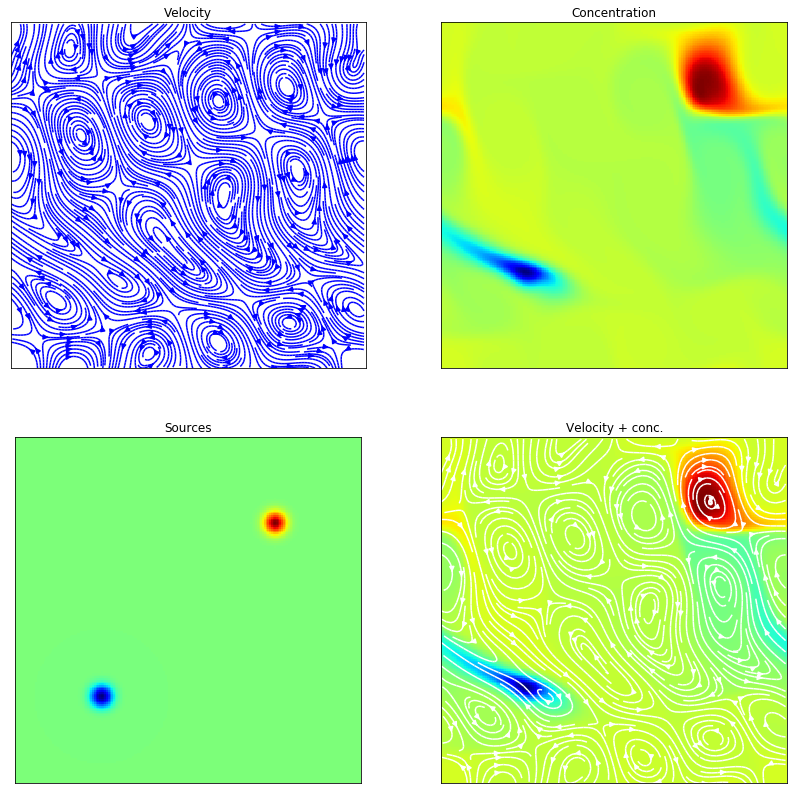

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
x,y=np.meshgrid(np.linspace(0,2*pi,N+1)[:-1],
                    np.linspace(0,2*pi,N+1)[:-1])
fig , axs= plt.subplots(nrows=2,ncols=2,figsize=(14,14))
axs[0,0].streamplot(N*x/(2*pi),N*y/(2*pi),res[-1][1],res[-1][2],color='b',density=4)
axs[0,0].set_title('Velocity')
axs[0,1].imshow(res[-1][0],cmap=plt.get_cmap('jet'))
axs[0,1].set_title('Concentration')
axs[1,0].imshow(res[-1][3],cmap=plt.get_cmap('jet'))
axs[1,0].set_title('Sources')
axs[1,1].imshow(res[-1][0],cmap=plt.get_cmap('jet'))
axs[1,1].streamplot(N*x/(2*pi),N*y/(2*pi),res[-1][1],res[-1][2],color='w',density=2)
axs[1,1].set_title('Velocity + conc.')
for ax in axs.flatten():
    ax.set_xlim([0,N])
    ax.set_ylim([0,N])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

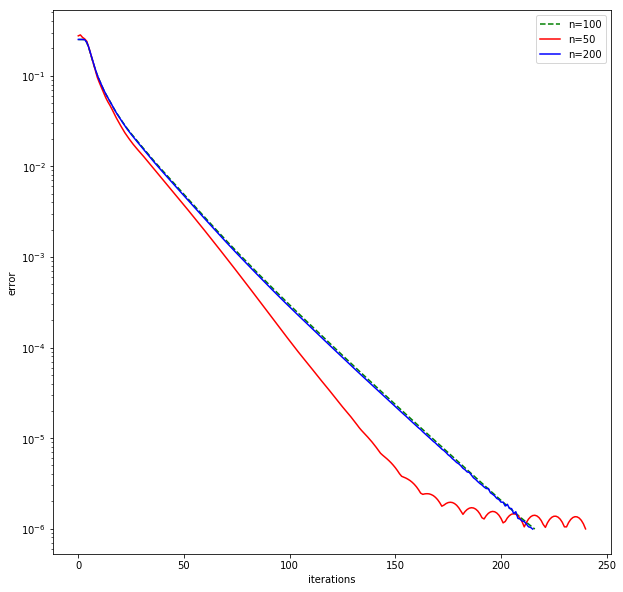

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
fig, ax= plt.subplots(figsize=(10,10))
ax.semilogy(res[-1][-1],'g--',label='n=100')
ax.semilogy(res[0][-1],'r',label='n=50')
ax.semilogy(res[-2][-1],'b',label='n=200')
plt.legend()
ax.set_xlabel('iterations')
ax.set_ylabel('error')
plt.show()